# Project 2
by:
- Rebecca Kuhlman
- Michael Amberg
- Sam Yao

## Business Understanding
Identifying the type of brain tumor a patient has is an important step in figuring out the treatment plan of a patient. They can be diagnosed via MRI imaging, leading to interest in using machine learning to diagnose the patient. Having a second opinion on brain tumor diagnoses would help improve patient care and outcomes, and lessen stress on doctors. A machine learning model could also speed up analysis time and pick out which patients are in need of urgent treatment.

In this dataset, there is glioma, meningioma, and pituitary tumors, as well as MRI images with no tumors.
Glioma tumors are usually malignant, while meningioma and pituitary tumors are usually benign. Different types of tumors are made of different types of cells and have a location where they are most likely to be located.
More information can be found at: https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084

There are many other types of tumors that future algorithms will be need to address. The majority of other types of tumors are more common in children, while the set we are dealing with are all adult brain images.

Because the model deals with health conditions that have extreme affects on the patient, model accuracy is extremely important. Furthermore, accuracy must fine-tuned to avoid fatal misdiagnosis. While incorrectly marking a patient with a benign tumor as malignant is wasteful, the adverse affects are minimal. Inversely, misdiagnosing a malignant tumor as benign may have fatal effects for the patient. Therefore, the designed model must minimize the rate of false negatives with accuracy of 95% or more.

It should be noted that the majority of misdiagnose of brain tumors happen before a brain scan or related test is ordered.
https://paulandperkins.com/brain-tumors/


## Data Preparation

Several helpful sources that helped this part of the section include:
- [1] https://pillow.readthedocs.io/en/stable/handbook/tutorial.html
- [2] https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6

In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image # Utilized Source [2]

'''img = Image.open("./Training/glioma_tumor/gg (1).jpg") # Utilized Source [1]
img_arr = np.array(img)
new_arr = list()
for x in img_arr:
    for y in x:
        new_arr.append(y)
print(len(new_arr))'''
# This method creates the data, whether training or testing, in the form we desire
# Uses code from source [2] to create the training datasets
def create_dataset(img_folder):
    # Read through all files in "./Training"
    img_data_array= []
    class_name=[]

    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= np.array(Image.open(image_path).convert("L").resize((512,512)))
            image = image.flatten() #Vectorizes each image
            
            image = image.astype('float16')#float32
            image /= 255

            img_data_array.append(image)
            class_name.append(dir1)
    # return array with training data.
    img_data_array = np.asarray(img_data_array, dtype=np.ndarray)
    return img_data_array, class_name

In [3]:
df_training, training_classes = create_dataset("./Training")
#df_testing, testing_classes = create_dataset("./Testing")

In [50]:
df_training[38]

(262144,)

## Data Reduction

PCA

Sources:
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [7]:
# get some of the specifics of the dataset
dfTrain = pd.DataFrame(df_training)
dfTarget = pd.DataFrame(training_classes)
X = dfTrain
y = training_classes

n_samples, n_features = X.shape
h=w = 512
n_classes = 4

print("n_samples: {}".format(n_samples))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))

n_samples: 1876
n_classes: 4
Original Image Sizes 512 by 512


In [9]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenBrains from %d brains" % (
    n_components, h))

pca = PCA(n_components= n_components)
pca.fit(X.copy())
eigenBrains = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenBrains from 512 brains


MemoryError: Unable to allocate 3.66 GiB for an array with shape (1876, 262144) and data type float64

In [ ]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

idx_to_reconstruct = 1
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

 randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.

In [8]:
print ("Extracting the top %d eigenBrains from %d brains" % (
    n_components, X.shape[0]))
rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(X.copy())
eigenBrains = rpca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenBrains from 1876 faces


NameError: name 'PCA' is not defined

Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

feature extraction upon the images using DAISY. Try different parameters for your image data.

In [ ]:
from skimage.feature import daisy

# lets first visualize what the daisy descriptor looks like
features, img_desc = daisy(img,
                           step=20,
                           radius=20,
                           rings=2,
                           histograms=8,
                           orientations=8,
                           visualize=True)
imshow(img_desc)
plt.grid(False)

In [ ]:
# now let's understand how to use it
features = daisy(img, step=20, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

In [ ]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=20, radius=20,
                 rings=2, histograms=8, orientations=4,
                 visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(h,w))
test_feature.shape

In [ ]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

Does this feature extraction method show promise for your prediction task? Why?
Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.

## Exceptional Work 😡

Additional feature extraction techniques(Gabor filters, keypoint matching, ordered gradients) Several are provided in the notebooks and you might research techniques known in the computer vision literature.
Does this feature extraction method show promise for your prediction task? Why?
Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.

Automatically created module for IPython interactive environment


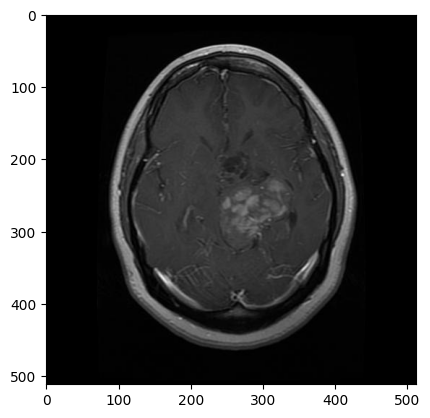

In [15]:
from matplotlib import pyplot as plt
#!/usr/bin/env python

import numpy as np
import cv2

def build_filters():
 filters = []
 ksize = 31
 for theta in np.arange(0, np.pi, np.pi / 16):
     kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
     kern /= 1.5*kern.sum()
     filters.append(kern)
 return filters

def process(img, filters):
 accum = np.zeros_like(img)
 for kern in filters:
     fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
     np.maximum(accum, fimg, accum)
 return accum

if __name__ == '__main__':
 import sys

 print (__doc__)
 img_fn = "./Training/glioma_tumor/gg (1).jpg"
# img = Image.open("./Training/glioma_tumor/gg (1).jpg")

 img = cv2.imread(img_fn)
 if img is None:
     print ('Failed to load image file:', img_fn)
     sys.exit(1)

 filters = build_filters()

 res1 = process(img, filters)
 plt.imshow(img)

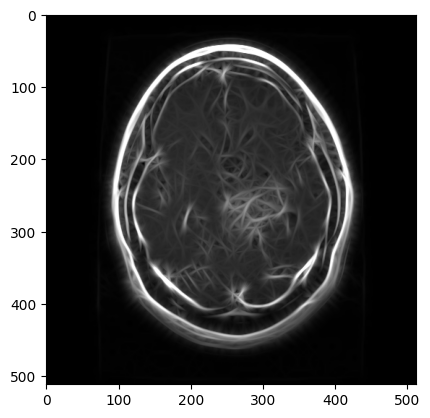

In [14]:
plt.imshow(res1)

Where the tumor is much more visable, but this is not an ideal visualization. We will try editing the filters by altering the k size from 30 to 15

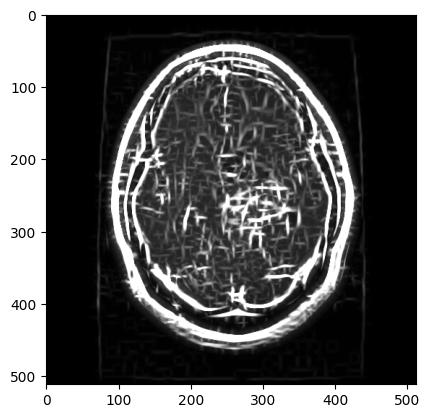

In [33]:
def build_filters2():
 filters = []
 ksize = 15
 for theta in np.arange(0, np.pi, np.pi / 16):
     kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
     kern /= 1.5*kern.sum()
     filters.append(kern)
 return filters
filters2 = build_filters2()
res2 = process(img, filters)
plt.imshow(res2)

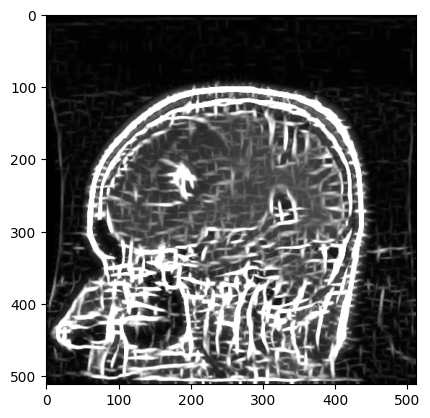

In [34]:
imgFile2 = "./Training/glioma_tumor/gg (250).jpg"
img2 = cv2.imread(imgFile2)
if img2 is None:
     print ('Failed to load image file:', imgFile2)
     sys.exit(1)
plt.imshow(img2)

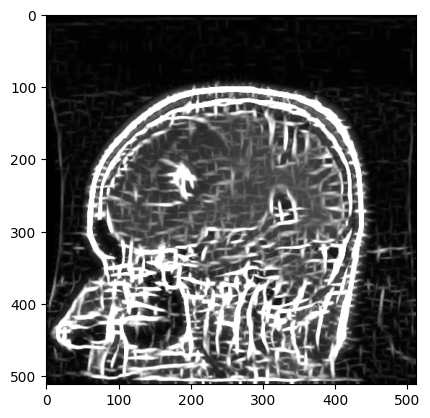

In [35]:
res2 = process(img2, filters)
plt.imshow(res2)

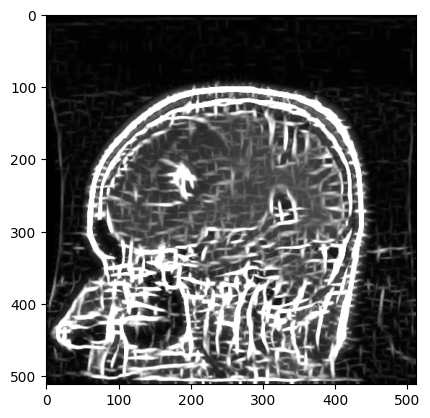

In [36]:
res2f2 = process(img2, filters2)
plt.imshow(res2f2)

For this set of brain images, the tumor is marked, but there is noise coming from none brain components. Ideally, a prediction model would take this into account.

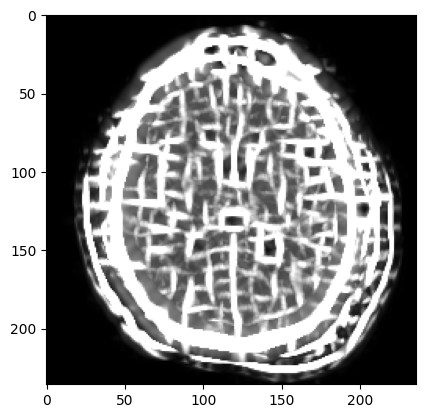

In [29]:
imgFile3 = "./Training/no_tumor/image(13).jpg"
img3 = cv2.imread(imgFile3)
if img3 is None:
     print ('Failed to load image file:', imgFile3)
     sys.exit(1)
res3 = process(img3, filters2)
plt.imshow(res3)

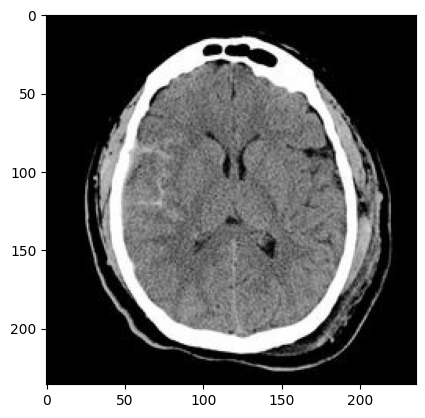

In [30]:
plt.imshow(img3)

This image has no tumor, making the filter try harder to find an area that doesn't exist.